# Problem 5: DQN (Deep Q Network)

In [1]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import imageio

from typing import Dict, List, Union, Tuple, Optional
from copy import deepcopy

## Cart Pole

### Observation Space
The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:

### Action Space
The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

$\cdot$ 0: Push cart to the left

$\cdot$ 1: Push cart to the right

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

### Rewards
Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 500 for v1 and 200 for v0.

Reference: https://gymnasium.farama.org/environments/classic_control/cart_pole/

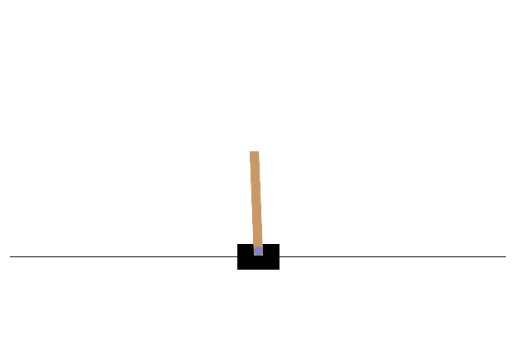

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=1)

img = env.render()

plt.imshow(img)
plt.axis("off")
plt.show()

## Mountain Car

### Observation Space
The observation is a ndarray with shape (2,) with the values corresponding to the following positions and velocities:

### Action Space
There are 3 discrete deterministic actions:

$\cdot$ 0: Accelerate to the left

$\cdot$ 1: Don’t accelerate

$\cdot$ 2: Accelerate to the right

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

### Rewards
The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep.

Reference: https://gymnasium.farama.org/environments/classic_control/mountain_car/

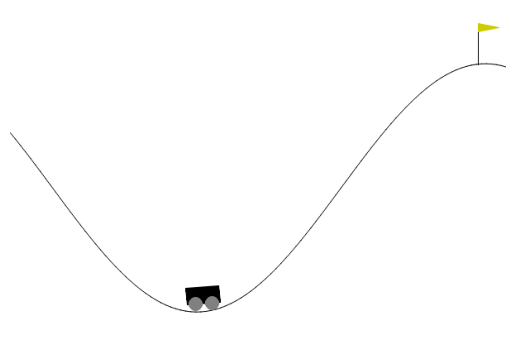

In [3]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
obs, info = env.reset(seed=1)

img = env.render()

plt.imshow(img)
plt.axis("off")
plt.show()

## Start Algorithm

In this lab, we will apply deep learning as function approximations in reinforcement learning. 

Reference: DQN https://arxiv.org/abs/1312.5602

In tabular Q-learning, we maintain a table of state-action pairs $(s,a)$ and save one action value for each entry $Q(s,a),\forall (s,a)$. At each time step $t$, we are in state $s_t$, then we choose action based on $\epsilon$-greedy strategy. With prob $\epsilon$, choose action uniformly random; with prob $1-\epsilon$, choose action based on $$a_t = \arg\max_a Q(s_t,a)$$ 

We then get the instant reward $r_t$, update the Q-table using the following rule

$$Q(s_t,a_t) \leftarrow (1-\alpha)Q(s_t,a_t) + \alpha (r_t + \max_a \gamma Q(s_{t+1},a))$$

where $\alpha \in (0,1)$ is learning rate. The algorithm is shown to converge in tabular cases. However, in cases where we cannot keep a table for state and action, we need function approximation. Consider using neural network with parameter $\theta$, the network takes as input state $s$ and action $a$. (*there are alternative parameterizations here*). Let $Q_\theta(s,a)$ be the output of the network, to estimate the optimal action value function in state $s$ and take action $a$ (and follow optimal policy thereafter). 

$$Q_\theta(s,a) \approx Q^\ast(s,a)$$

### Bellman optimality equation

We will use Bellman optimality equation to find $\theta$ such that the above approximation holds better. Recall that for optimal Q function $Q^\ast(s,a)$ the following holds for all $(s,a)$

$$Q^\ast(s_t,a_t) = \max_a \mathbb{E}\big[r_t + \gamma Q^\ast(s_{t+1},a)\big]$$

Hence a natural objective to consider is 

$$\min_\theta\  \left(Q_\theta(s_t,a_t) - \max_a \mathbb{E}\big[r_t + \gamma Q_\theta(s_{t+1},a)\big]\right)^2$$

Let us first build a neural network $Q_\theta(s,a)$ as required above.

In [ ]:
# Define the Q-network
class QNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dims:[List[int]],
        activation: nn.Module = nn.ReLU,
    ) -> None:
        super(QNetwork, self).__init__()
        hidden_dims = [input_dim] + list(hidden_dims)
        model = []

        #################################################################
        #                             TODO                              #
        #################################################################
        """
        Model Sequential:
        input -> hidden(1) -> hidden(2) -> ... -> hidden(last) -> output
        with activation function(ReLU function)

        Define the initial, hidden, and output layers
        """
        for in_dim, out_dim in zip(hidden_dims[:-1], hidden_dims[1:]):
            model += [nn.Linear(in_dim, out_dim), activation()]

        model += [nn.Linear(hidden_dims[-1], output_dim)]
        self.model = nn.Sequential(*model)
        
        #################################################################
        
        self.model = nn.Sequential(*model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

We can hence collect a bunch of samples $(s_t,a_t,r_t,s_{t+1})$, and compute the targets using the current network. Let the target be $d_i$ as the $i$-th target

$$d_i = \max_a r_t + \gamma Q_\theta(s_{t+1},a)$$

And then feed this value into the computational graph and minimize the Bellman error loss. This procedure has been shown to be fairly unstable. The reference paper has offered two techniques to stabilize the training process: target network and replay buffer.

#### **1. Replay Buffer**
Maintain a buffer $R$ to store trainsition tuples $(s_t,a_t,r_t,s_{t+1})$, when we minimize the Bellman error. When optimizing the Bellman error loss, we sample batches from the replay buffer and compute gradients for update on these batches. In particular, in each update, we sample $N$ tuples from buffer $(s_t,a_t,r_t,s_{t+1}) \sim R$ and then compute
loss 

$$\frac{1}{N} \sum_{i=1}^N (Q_\theta(s_i,a_i) - \max_a (r_i + \gamma Q_\theta(s_i^\prime,a))^2$$

and update parameters using backprop.

#### **2. Target Network**
Maintain a target network in addition to the original pricipal network. The target network is just a copy of the original network but the parameters are not updated by gradients. The target network $\theta_{\text{target}}$ is updated for every $\tau$ time steps. 

$$\theta_{\text{target}} \leftarrow (1-\tau)*\theta_{\text{target}} + \tau * \theta_{\text{update}}$$

Target network is used to compute the targets for update

$$d_i = \max_a r_t + \gamma Q_{\theta^{-}}(s_{i}^\prime,a)$$

the targets are used in the loss function to update the principal network parameters. This slowly updated target network ensures that the targets come from a relatively stationary distribution and hence stabilize learning.

In [ ]:
# Define the DQN agent
class DQNAgent:
    def __init__(
        self,
        q_network: nn.Module,
        optimizer: optim.Optimizer,
        input_dim: int,
        output_dim: int,
        epsilon_start: float,
        epsilon_final: float,
        epsilon_decay: float,
        target_update: int,
        batch_size: int,
        memory_capacity: int,
        gamma: float,
        tau: float
    ) -> None:
        self.q_network, self.target_network = q_network, deepcopy(q_network)
        self.target_network.eval()
        self.optimizer = optimizer
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.epsilon = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay

        self.target_update = target_update
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity
        self.gamma = gamma
        self.tau = tau
        
        self.memory = []
        self.steps = 0

    def select_action(self, state):
        #################################################################
        #                             TODO                              #
        #################################################################
        """
        With probability epsilon, select a random action a_t
        Otherwise, select a_t = argmax_a Q(s, a | theta)
        """
        




        
        #################################################################

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_capacity:
            self.memory.pop(0)

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample a mini-batch from the replay memory
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        #################################################################
        #                             TODO                              #
        #################################################################
        """
        Compute Q-values for the current states
        """
        q_values = 
        q_values = 

        #################################################################

        #################################################################
        #                             TODO                              #
        #################################################################
        """
        Compute Q-values for the next states using the target network
        """
        next_q_values = 

        #################################################################

        #################################################################
        #                             TODO                              #
        #################################################################
        """
        Compute the expected Q-values
        """
        expected_q_values = 

        #################################################################

        # Compute the loss
        loss = nn.MSELoss()(q_values, expected_q_values)

        # Update the Q-network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon for exploration
        #################################################################
        #                             TODO                              #
        #################################################################
        """
        Compute the decay epsilon
        """
        self.epsilon = 

        self.steps += 1
        #################################################################
        #                             TODO                              #
        #################################################################
        """
        Update the target network every 'target_update' steps
        """
        if self.steps % self.target_update == 0:
            for t, q in zip(self.target_network.parameters(), self.q_network.parameters()):
                t.data.copy_(                                    )

        #################################################################
        

In [ ]:
# Hyperparameters
epsilon_start = 1.0  # Initial epsilon for epsilon-greedy exploration
epsilon_final = 0.01  # Final epsilon
epsilon_decay = 0.995  # Epsilon decay rate
target_update = 10  # Update the target network every 'target_update' steps
memory_capacity = 10000  # Replay memory capacity
num_episodes = 200  # Number of episodes to train

#################################################################
#                             TODO                              #
#################################################################
lr = 1e-3  # Learning rate
gamma = 0.99  # Discount factor
tau = 0.1 # Parameters update factor
batch_size = 64  # Mini-batch size
hidden_dims = [20, 20] # Hidden layers
#################################################################


# Initialize the environment and the agent
env = gym.make("CartPole-v1", render_mode="rgb_array")
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

q_network = QNetwork(input_dim, output_dim, hidden_dims)
optimizer = optim.Adam(q_network.parameters(), lr=lr)
agent = DQNAgent(
    q_network=q_network,
    optimizer=optimizer,
    input_dim=input_dim,
    output_dim=output_dim,
    epsilon_start=epsilon_start,
    epsilon_final=epsilon_final,
    epsilon_decay=epsilon_decay,
    target_update=target_update,
    batch_size=batch_size,
    memory_capacity=memory_capacity,
    gamma=gamma,
    tau=tau
)

record = []
frames = []

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward

        if episode == num_episodes - 1:
            frames.append(env.render())

    record.append(total_reward)
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

env.close()

imageio.mimsave("cartpole_last.gif", frames, fps=30)
print("GIF saved as cartpole_last.gif")

plt.imshow(frames[0])
plt.axis("off")
plt.show()

In [ ]:
# plot [episode, reward] history
x = [i+1 for i in range(len(record))]
plt.plot(x, record)
plt.title('episode rewards')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()

In [ ]:
# Hyperparameters
epsilon_start = 1.0  # Initial epsilon for epsilon-greedy exploration
epsilon_final = 0.01  # Final epsilon
epsilon_decay = 0.995  # Epsilon decay rate
target_update = 10  # Update the target network every 'target_update' steps
memory_capacity = 10000  # Replay memory capacity
num_episodes = 500  # Number of episodes to train

#################################################################
#                             TODO                              #
#################################################################
lr = 1e-3  # Learning rate
gamma = 0.99  # Discount factor
tau = 0.1 # Parameters update factor
batch_size = 64  # Mini-batch size
hidden_dims = [20, 20] # Hidden layers
#################################################################


# Initialize the environment and the agent
env = gym.make("MountainCar-v0", render_mode="rgb_array")
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

q_network = QNetwork(input_dim, output_dim, hidden_dims)
optimizer = optim.Adam(q_network.parameters(), lr=lr)
agent = DQNAgent(
    q_network=q_network,
    optimizer=optimizer,
    input_dim=input_dim,
    output_dim=output_dim,
    epsilon_start=epsilon_start,
    epsilon_final=epsilon_final,
    epsilon_decay=epsilon_decay,
    target_update=target_update,
    batch_size=batch_size,
    memory_capacity=memory_capacity,
    gamma=gamma,
    tau=tau
)

record = []
frames = []

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward

        if episode == num_episodes - 1:
            frames.append(env.render())

    record.append(total_reward)
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

env.close()

imageio.mimsave("MountainCar_last.gif", frames, fps=30)
print("GIF saved as MountainCar_last.gif")

plt.imshow(frames[0])
plt.axis("off")
plt.show()

In [ ]:
# plot [episode, reward] history
x = [i+1 for i in range(len(record))]
plt.plot(x, record)
plt.title('episode rewards')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()